In [400]:
import time
import requests
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from py2neo import Graph, Node, Relationship

In [434]:
import requests

#   The credentials to be used
login = {
    'username': 'jww@mit.edu',
    'password': 'e38qDkG$tJ'
}

#   Send credentials to login url to retrieve token. Raise
#   an error, if the return code indicates a problem.
#   Please use the URL of the system you'd like to access the API
#   in the example below.
resp_auth = requests.post('https://app.dimensions.ai/api/auth.json', json=login)
resp_auth.raise_for_status()

#   Create http header using the generated token.
headers = {
    'Authorization': "JWT " + resp_auth.json()['token']
}

In [414]:
graph = Graph( "bolt://matlaber5.media.mit.edu:7687", auth=('neo4j','myneo'))
print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

def neo4j_to_df(query, graph):
    print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df
    
top_5 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science']
top_10 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science', 'Journal of the American Chemical Society', 'JAMA', 'The New England Journal of Medicine', 'Nature Genetics', 'Neuron']
top_42 = ['Angewandte Chemie','Blood','Cancer Cell','Cancer Discovery','Cancer Research','Cell','Cell Host & Microbe','Cell Metabolism','Cell Stem Cell','Chemistry & Biology','The EMBO Journal','Genes & Development','Immunity','Journal of Neurology','Journal of the American Chemical Society','JAMA','Journal of Biological Chemistry','Journal of Cell Biology','Journal of Clinical Investigation','Journal of Experimental Medicine','Journal of Medicinal Chemistry','The Lancet','Nature Cell Biology','Nature Chemical Biology','Nature Chemistry','Nature Medicine','Nature Methods','Nature','Nature Biotechnology','The New England Journal of Medicine','Neuron','Nature Genetics','Nature Immunology','Nature Neuroscience','Nature Structural & Molecular Biology','PLOS Biology','PLOS Genetics','PLOS Pathogens','Proceedings of the National Academy of Sciences of the United States of America','Science Signaling','Science Translational Medicine','Science']

Connected to graph database with 278,432,359 nodes and 1,844,501,832 relationships!


In [350]:
# long numbers to human readable string
def human_format(num):
    try:
        num = float('{:.3g}'.format(float(num)))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
    except:
        return num

In [415]:
from requests.exceptions import HTTPError
def dimensions_to_df(query):
    try:
        resp = requests.post(
            'https://app.dimensions.ai/api/dsl.json',
            data=query.encode(),
            headers=headers)
        resp.raise_for_status()
    except HTTPError as http_err:
        print('Error while executing query: ', query)
        raise http_err
    ret = resp.json()
    keys = list(ret.keys())
    keys.remove('_stats')
    if len(keys):
        df = pd.DataFrame(ret[keys[0]])
    else:
        df = pd.DataFrame()
    return df, ret['_stats']

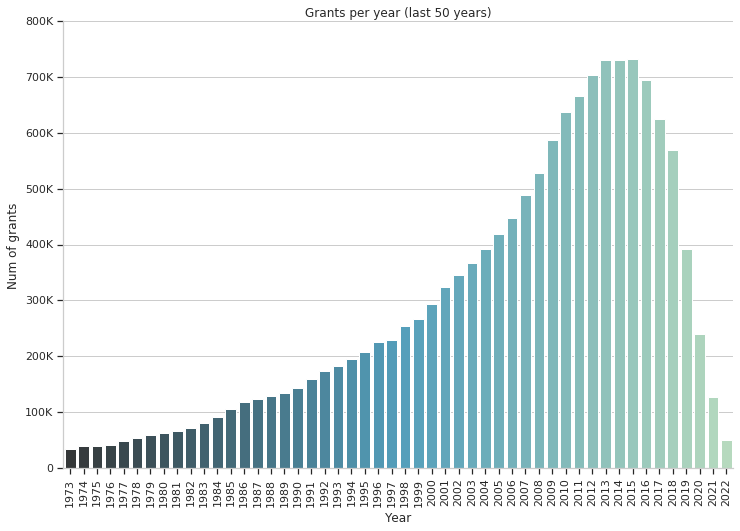

In [368]:
query='search grants return active_year limit 50'
df, stats = dimensions_to_df(query)

ax = sns.barplot(x = "id", y = "count", data=df, palette="GnBu_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Grants per year (last 50 years)')
ax.set_ylabel('Num of grants')
ax.set_xlabel('Year')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels([human_format(tick) for tick in ax.get_yticks().tolist()])
plt.show()

In [37]:
query = ('search grants where resulting_publication_ids is not empty return grants limit 1')
print("Number of grants WITH resulting publications:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search grants where resulting_publication_ids is empty return grants limit 1')
print("Number of grants WITHOUT resulting publications:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where supporting_grant_ids is not empty return publications limit 1')
print("Number of publications WITH a supporting grant:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where supporting_grant_ids is empty return publications limit 1')
print("Number of publications WITHOUT a supporting grant:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funders is not empty return publications limit 1')
print("Number of publications WITH funders:\t\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funders is empty return publications limit 1')
print("Number of publications WITHOUT funders:\t\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

Number of grants WITH resulting publications:		1,160,244
Number of grants WITHOUT resulting publications:	3,420,317
Number of publications WITH a supporting grant:		5,840,914
Number of publications WITHOUT a supporting grant:	95,394,656
Number of publications WITH funders:			10,745,126
Number of publications WITHOUT funders:			90,490,444


Number of funding countries:  61


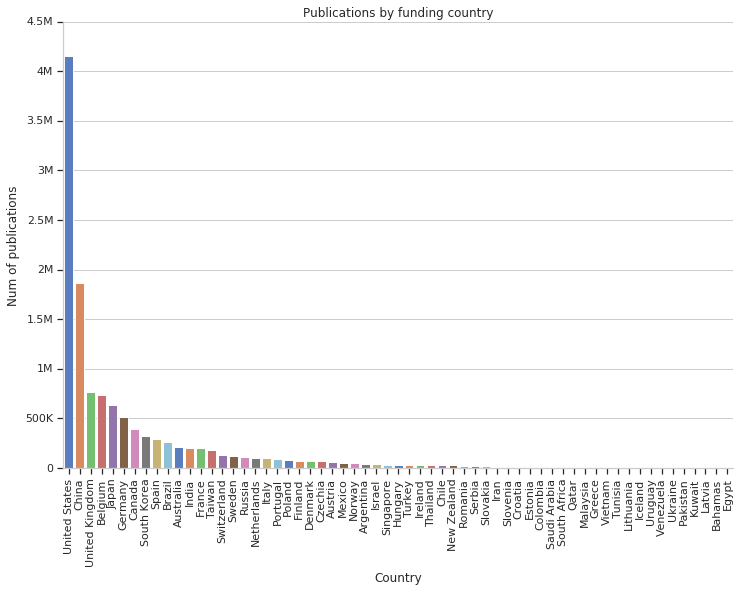

In [367]:
query = ('search publications return funder_countries limit 1000')
df, stats = dimensions_to_df(query)

print("Number of funding countries: ", len(df))

ax = sns.barplot(x = "name", y = "count", data=df, palette="muted")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Publications by funding country')
ax.set_ylabel('Num of publications')
ax.set_xlabel('Country')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels([human_format(tick) for tick in ax.get_yticks().tolist()])
plt.show()

Number of funding countries:  39


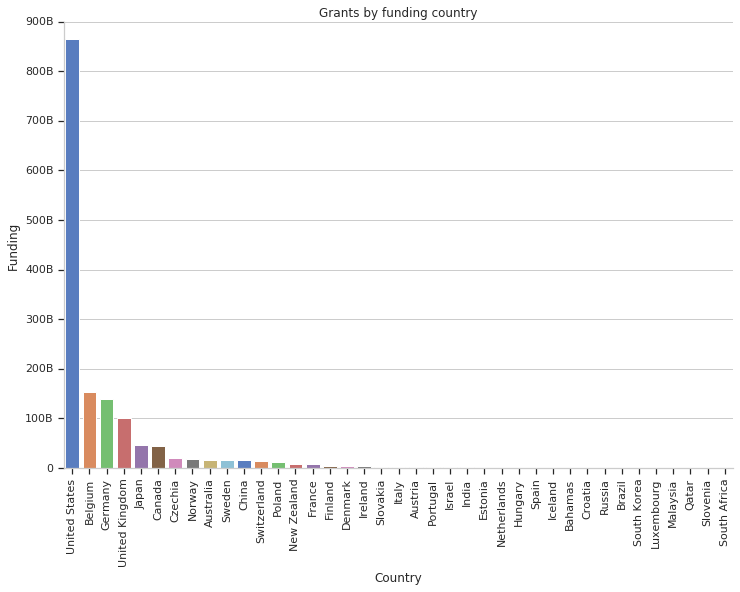

In [366]:
query = ('search grants return funder_countries aggregate funding sort by funding desc limit 1000')
df, stats = dimensions_to_df(query)

print("Number of funding countries: ", len(df))

ax = sns.barplot(x = "name", y = "funding", data=df, palette="muted")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Grants by funding country')
ax.set_ylabel('Funding')
ax.set_xlabel('Country')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels([human_format(tick) for tick in ax.get_yticks().tolist()])
plt.show()

# Maybe the funding number is in different currencies? the China columns seems odd

## From now on, focus on US funded grants/publication

In [46]:
query = ('search grants where funder_countries = "US" and resulting_publication_ids is not empty return grants limit 1')
print("Number of grants WITH resulting publications:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search grants where funder_countries = "US" and resulting_publication_ids is empty return grants limit 1')
print("Number of grants WITHOUT resulting publications:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funder_countries = "US" and supporting_grant_ids is not empty return publications limit 1')
print("Number of publications WITH a supporting grant:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funder_countries = "US" and supporting_grant_ids is empty return publications limit 1')
print("Number of publications WITHOUT a supporting grant:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

# seems like most of the missing publication -> grant data is non-US

Number of grants WITH resulting publications:		504,799
Number of grants WITHOUT resulting publications:	893,074
Number of publications WITH a supporting grant:		3,277,688
Number of publications WITHOUT a supporting grant:	876,120


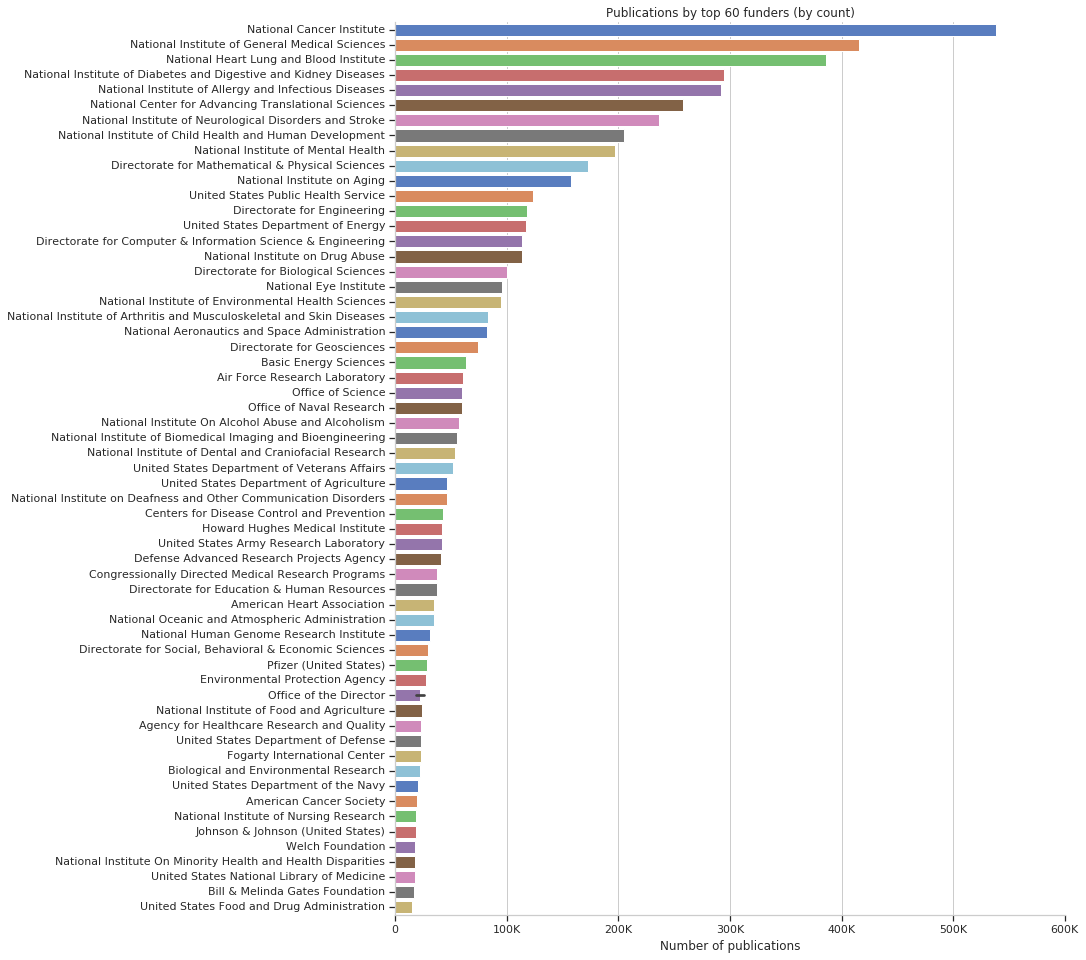

In [365]:
query = ('search publications where funder_countries = "US" return funders limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60)


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "count", data=only_us, orient="h", palette="muted")
ax.set_title('Publications by top 60 funders (by count)')
ax.set_ylabel('')
ax.set_xlabel('Number of publications')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

In [380]:
# check which foundations are in the DB
query = ('search publications where funders.name~"MacArthur" return funders limit 1000')
df, stats = dimensions_to_df(query)
df.head(20)

# no MacArthur Foundation.. :/

""


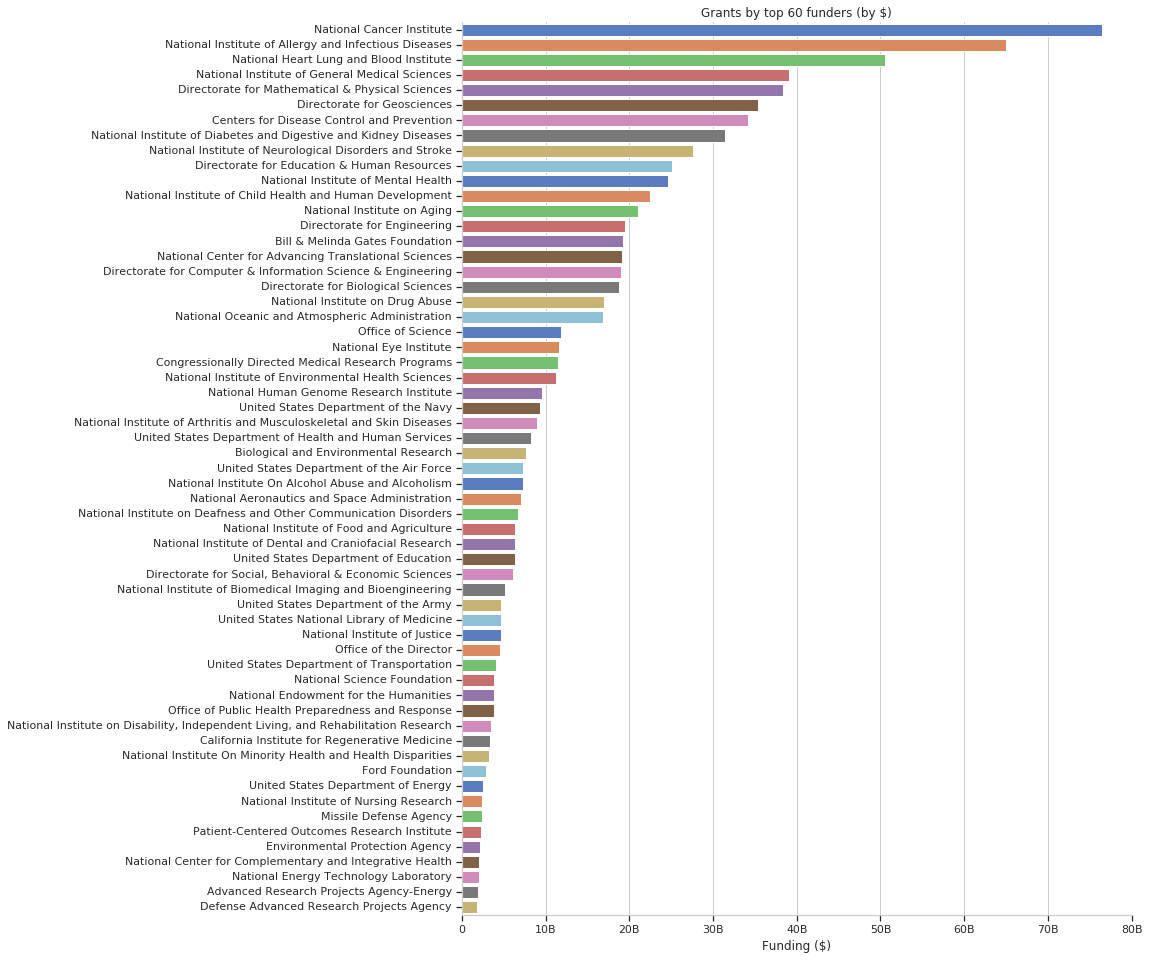

In [364]:
query = ('search grants where funder_countries = "US" return funders aggregate funding  sort by funding desc limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60)


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "funding", data=only_us, orient="h", palette="muted")
ax.set_title('Grants by top 60 funders (by $)')
ax.set_ylabel('')
ax.set_xlabel('Funding ($)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

In [432]:
# fetch all grants per specific funder
funder = "Defense Advanced Research Projects Agency"
#funder = "Bill & Melinda Gates Foundation"

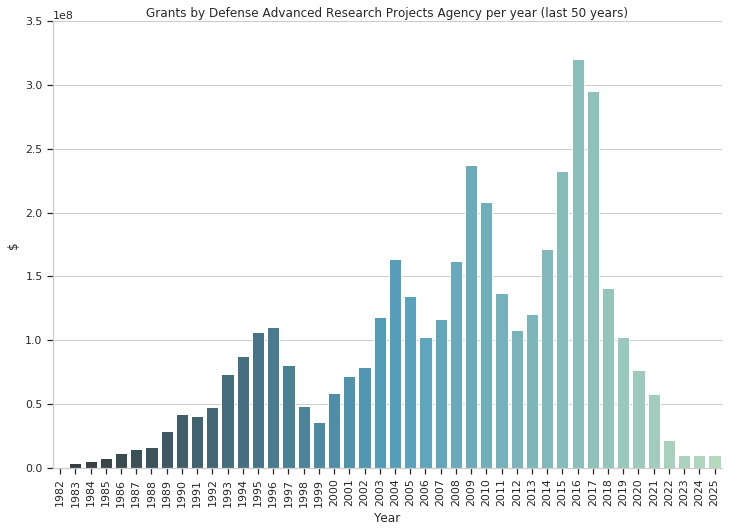

In [435]:
query = (
    'search grants \
    where funders.name = "' + funder + '" \
    and active_year >= 1969 \
    return active_year aggregate funding limit 100'
)

df, stats = dimensions_to_df(query)

ax = sns.barplot(x = "id", y = "funding", data=df, palette="GnBu_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Grants by ' + funder + ' per year (last 50 years)')
ax.set_ylabel('$')
ax.set_xlabel('Year')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

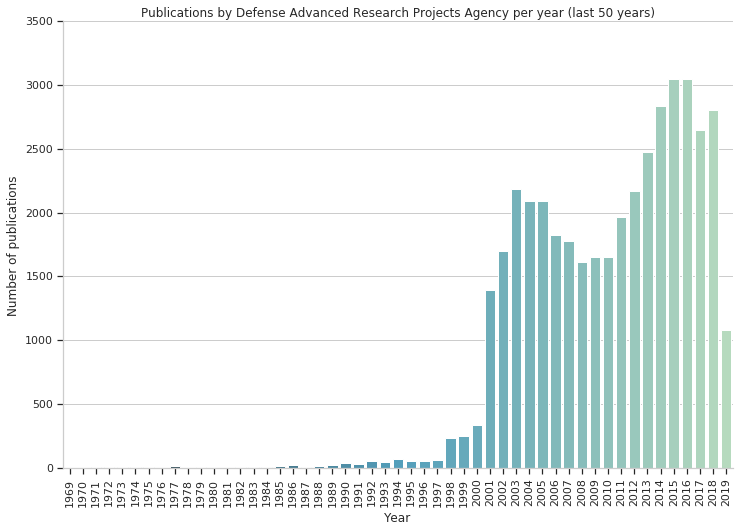

In [436]:
query = (
    'search publications \
    where funders.name = "' + funder + '" \
    and year >= 1969 \
    return year limit 100'
)

df, stats = dimensions_to_df(query)

ax = sns.barplot(x = "id", y = "count", data=df, palette="GnBu_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Publications by ' + funder + ' per year (last 50 years)')
ax.set_ylabel('Number of publications')
ax.set_xlabel('Year')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

In [437]:

print("Fetching grants for", funder)
query = (
    'search grants \
    where funders.name = "' + funder + '" \
    return grants [all - abstract - original_title] \
    sort by id \
    limit 1000 skip '
)

big_df, stats = dimensions_to_df(query + "0")
total = stats['total_count']

if total > 50000:
    raise Exception("Total number of grants for this funder exceeds the maximum fetch-able amount", total)

start = 1
step = 1000
idx = start
for i in range(start * step, total, step):
    time.sleep(2)
    print("%.1f%%" % (float(i) * 100 / total))
    df, stats = dimensions_to_df(query + "%d" % i)
    big_df = pd.concat([big_df, df])
print("Done")

Fetching grants for Defense Advanced Research Projects Agency
17.1%
34.2%
51.4%
68.5%
85.6%
Done


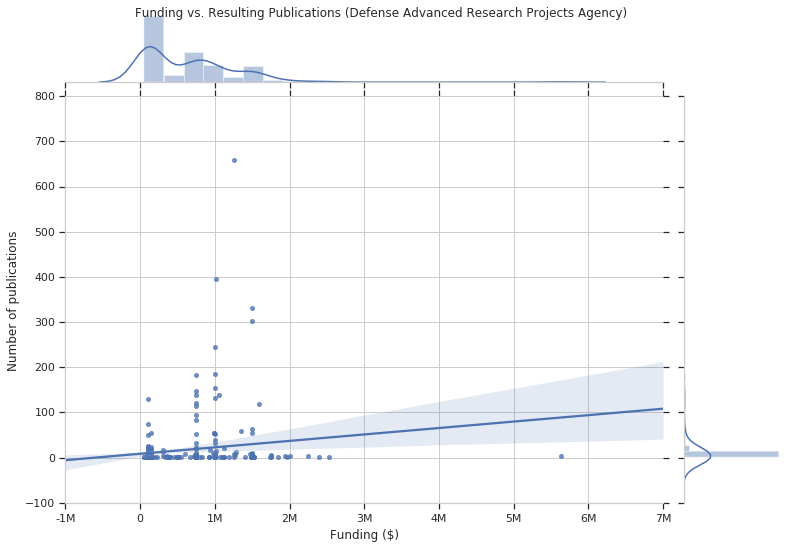

In [438]:
big_df['resulting_publication_len'] = big_df["resulting_publication_ids"].str.len().fillna(0)

g = sns.jointplot(x="funding_usd", y="resulting_publication_len", 
                  data=big_df[big_df['resulting_publication_len'] > 0], kind="reg")
g.fig.suptitle('Funding vs. Resulting Publications (' + funder + ')') 
g.set_axis_labels('Funding ($)', 'Number of publications')
g.ax_marg_y.grid('off')
g.ax_marg_x.grid('off')
g.ax_marg_x.axes.xaxis.tick_bottom()
g.ax_marg_y.axes.yaxis.tick_left()
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.ax_joint.set_xticklabels([human_format(tick) for tick in g.ax_joint.get_xticks().tolist()])
plt.show()

In [439]:
many_pubs = 5
grants_with_many_pubs = big_df[big_df['resulting_publication_len'] >= many_pubs]

print("Number of grants with over %d publications: %d" % (many_pubs, len(grants_with_many_pubs)))
i = 0
slice_size = 400 # cannot fetch too many publications IDs at once
new_col = []
for index, row in grants_with_many_pubs.iterrows():
    i += 1
    print("%d/%d" % (i, len(grants_with_many_pubs)))
    pubs_ids = ['"%s"' % s for s in row['resulting_publication_ids']]
    altmetric_sum = 0
    times_cited_sum = 0
    for j in range(0, len(pubs_ids), slice_size):
        k = min(i + slice_size, len(pubs_ids))
        query = (
            'search publications \
            where id in [%s] \
            return publications [altmetric + times_cited] \
            limit %d' % (','.join(pubs_ids[i:k]), k - i))
        try:
            df, stats = dimensions_to_df(query)
        except:
            print("%d was problematic!" % i)
            time.sleep(2)
            continue
        for index2, pub in df.fillna(0).iterrows():
            altmetric_sum += pub.get('altmetric', 0)
            times_cited_sum += pub.get('times_cited', 0)
        time.sleep(2)
    new_col.append({
        'altmetric_sum' : altmetric_sum,
        'altmetric_avg' : float(altmetric_sum) / len(pubs_ids),
        'times_cited_sum' : times_cited_sum,
        'times_cited_avg' : float(times_cited_sum) / len(pubs_ids)
    })

Number of grants with over 5 publications: 85
1/85
2/85
3/85
4/85
5/85
6/85
7/85
8/85
9/85
10/85
11/85
12/85
13/85
14/85
15/85
16/85
17/85
18/85
19/85
20/85
21/85
22/85
23/85
24/85
25/85
26/85
27/85
28/85
29/85
30/85
31/85
32/85
33/85
34/85
35/85
36/85
37/85
38/85
39/85
40/85
41/85
42/85
43/85
44/85
45/85
46/85
47/85
48/85
49/85
50/85
51/85
52/85
53/85
54/85
55/85
56/85
57/85
58/85
59/85
60/85
61/85
62/85
63/85
64/85
65/85
66/85
67/85
68/85
Error while executing query:  search publications         where id in ["pub.1000010061","pub.1000025030","pub.1001208906","pub.1001504421","pub.1001596315","pub.1001691754","pub.1002438130","pub.1002517590","pub.1002884090","pub.1003105189","pub.1003127425","pub.1003289825","pub.1003713557","pub.1003741918","pub.1004161516","pub.1004348325","pub.1004807404","pub.1004989987","pub.1005038179","pub.1005089497","pub.1005093018","pub.1005100957","pub.1005414637","pub.1005540349","pub.1005569948","pub.1005604261","pub.1005789906","pub.1006053640","pub.100

69/85
70/85
71/85
72/85
73/85
74/85
75/85
76/85
77/85
78/85
79/85
80/85
81/85
82/85
83/85
84/85
85/85


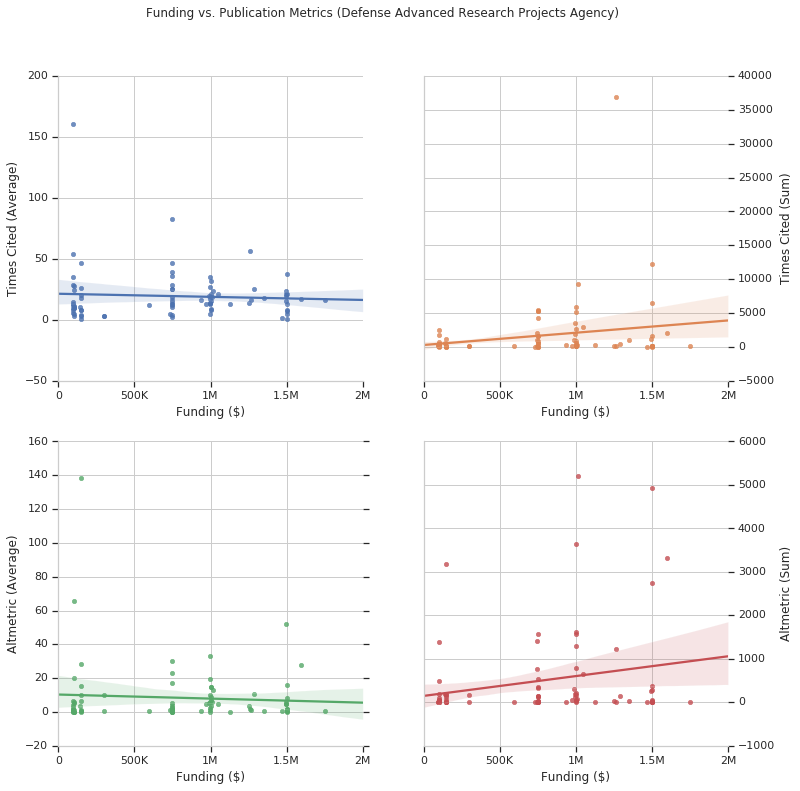

In [465]:
new_df = pd.concat([grants_with_many_pubs.reset_index(), pd.DataFrame(new_col)], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Funding vs. Publication Metrics (' + funder + ')') 

sns.regplot(ax = axes[0][0], x="funding_usd", y="times_cited_avg", data=new_df)
axes[0][0].set_ylabel('Times Cited (Average)')
axes[0][0].yaxis.tick_left()
sns.regplot(ax = axes[0][1], x="funding_usd", y="times_cited_sum", data=new_df)
axes[0][1].set_ylabel('Times Cited (Sum)')
axes[0][1].yaxis.set_label_position("right")
axes[0][1].yaxis.tick_right()
sns.regplot(ax = axes[1][0], x="funding_usd", y="altmetric_avg", data=new_df)
axes[1][0].set_ylabel('Altmetric (Average)')
axes[0][0].yaxis.tick_left()
sns.regplot(ax = axes[1][1], x="funding_usd", y="altmetric_sum", data=new_df)
axes[1][1].set_ylabel('Altmetric (Sum)')
axes[1][1].yaxis.set_label_position("right")
axes[1][1].yaxis.tick_right()

for axes2 in axes:
    for ax in axes2:
        ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
        ax.set_xlabel('Funding ($)')
        ax.xaxis.tick_bottom()


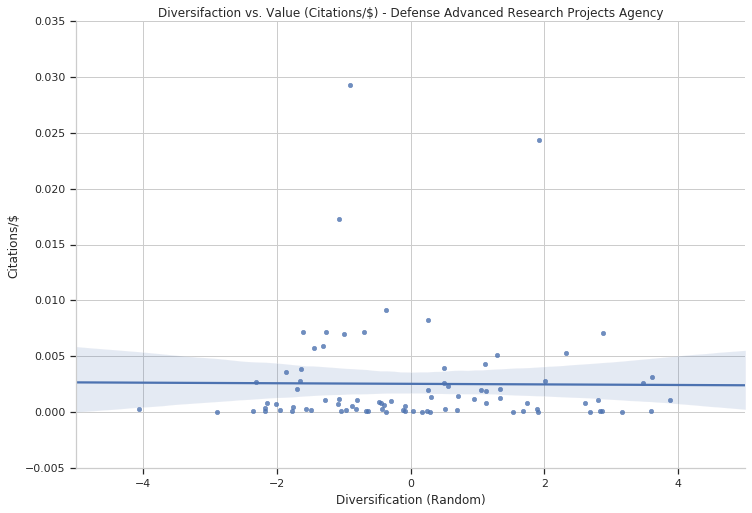

In [467]:
# Compute mean returns vs. diversification - hopefully see strong positive correlations
# Each grant is a "portfolio"
# Each resulting paper from a grant is an "asset"
# The asset's mean expected return is the times cited divided by the funding
# Assuming that each paper is given the same amount of funding from to grant's total funding (reasonable?)
# The assets' covariance is... well, need to define this one, specifically, need to define a distance function over
#   two papers' metadata which is very positive when they are similar (1 if equal) and negative when different (-1 for totally different) 

new_df["returns"] = new_df["times_cited_sum"] / new_df["funding_usd"]
new_df["diversification"] = 2 * np.random.randn(len(new_df))

ax = sns.regplot(x="diversification", y="returns", data=new_df)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Diversifaction vs. Value (Citations/$) - ' + funder)
ax.set_ylabel('Citations/$')
ax.set_xlabel('Diversification (Random)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

In [472]:
# top 5 grants
interesting_columns = [
    'title', 
    'FOR', 
    'FOR_first', 
    'active_year', 
    'funders', 
    'funding_usd', 
    'project_num', 
    'researchers',
    'researcher_details',
    'research_orgs',
    'resulting_publication_len',
    'altmetric_avg',
    'altmetric_sum',
    'times_cited_avg',
    'times_cited_sum',
    'returns'
]

new_df.nlargest(5, "returns")[interesting_columns]

,title,FOR,FOR_first,active_year,funders,funding_usd,project_num,researchers,researcher_details,research_orgs,resulting_publication_len,altmetric_avg,altmetric_sum,times_cited_avg,times_cited_sum,returns
67,"Design of Mobile, Wireless (Ad Hoc) Networks U...","[{'name': '0806 Information Systems', 'id': '2...",[{'name': '08 Information and Computing Scienc...,"[2003, 2004]","[{'country_name': 'United States', 'acronym': ...",1261940.0,HR0011-04-C-0029,"[{'first_name': 'Michael', 'last_name': 'Wellm...","[{'affiliations': [{'state': ' CA', 'country_c...",NaN,659.0,1.848255,1218.0,56.139605,36996.0,0.029317
81,Nanotechnology-Enhanced Sensor for Toxic Indus...,"[{'name': '0912 Materials Engineering', 'id': ...","[{'name': '09 Engineering', 'id': '2209'}, {'n...","[2007, 2008]","[{'country_name': 'United States', 'acronym': ...",98871.0,W31P4Q-08-C-0009,"[{'first_name': 'Dolly', 'research_orgs': ['gr...","[{'affiliations': [{'state': ' MA', 'country_c...","[{'country_name': 'United States', 'name': 'TI...",15.0,2.000000,30.0,160.466667,2407.0,0.024345
68,Dual-Output Broadband Linearized Modulator For...,"[{'name': '1005 Communications Technologies', ...","[{'name': '10 Technology', 'id': '2210'}]","[2003, 2004]","[{'country_name': 'United States', 'acronym': ...",99000.0,FA8750-04-C-0261,"[{'first_name': 'Suwat', 'research_orgs': ['gr...","[{'affiliations': [{'state': ' WA', 'country_c...","[{'country_name': 'United States', 'name': 'EO...",130.0,0.330769,43.0,13.169231,1712.0,0.017293
77,Agent-based Models of Multi-lateral Social Int...,[{'name': '0801 Artificial Intelligence and Im...,[{'name': '08 Information and Computing Scienc...,"[2012, 2013]","[{'country_name': 'United States', 'acronym': ...",1014128.0,HR0011-13-9-0005,"[{'first_name': 'Maarten', 'research_orgs': ['...","[{'affiliations': [{'state': ' CA', 'country_c...",NaN,396.0,13.146465,5206.0,23.409091,9270.0,0.009141
72,Portable Microwave Cold Atomic Clock,"[{'name': '0202 Atomic, Molecular, Nuclear, Pa...","[{'name': '02 Physical Sciences', 'id': '2202'...","[2014, 2015]","[{'country_name': 'United States', 'acronym': ...",1499833.0,HR0011-15-9-0007,"[{'first_name': 'Franklin', 'last_name': 'Asca...","[{'affiliations': [{'state': ' CO', 'country_c...",NaN,331.0,8.311178,2751.0,37.166163,12302.0,0.008202


In [425]:
many_pubs = 5
grants_with_many_pubs = big_df[big_df['resulting_publication_len'] >= many_pubs]

print("Number of grants with over %d publications: %d" % (many_pubs, len(grants_with_many_pubs)))
i = 0
for index, row in grants_with_many_pubs.iterrows():
    i += 1
    print("%d/%d" % (i, len(grants_with_many_pubs)))
    pubs_ids = ['"%s"' % s for s in row['resulting_publication_ids']]
    query = (
        'search publications \
        where id in [%s] \
        return publications [doi + title] \
        limit %d' % (','.join(pubs_ids), len(pubs_ids)))
    try:
        df, stats = dimensions_to_df(query)
        titles = df['title'].tolist()
        
        query_neo4j = """
        MATCH (q:Quanta)
        WHERE q.title in {}
        RETURN 
            q.id
        LIMIT {}
        """.format(titles, len(titles))
        df_neo4j = neo4j_to_df(query_neo4j, graph)
        
        print("Out of %d publications, managed to fetch %d from neo4j (by title)" % (len(df), len(df_neo4j)))
    except:
        print("%d was problematic!" % i)
    time.sleep(2)

Number of grants with over 10 publications: 141
1/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 10 from neo4j (by title)
2/141
Starting query... Done (0.00 minutes).
Out of 38 publications, managed to fetch 24 from neo4j (by title)
3/141
Starting query... Done (0.00 minutes).
Out of 60 publications, managed to fetch 31 from neo4j (by title)
4/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 3 from neo4j (by title)
5/141
Starting query... Done (0.00 minutes).
Out of 41 publications, managed to fetch 24 from neo4j (by title)
6/141
Starting query... Done (0.00 minutes).
Out of 11 publications, managed to fetch 0 from neo4j (by title)
7/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 5 from neo4j (by title)
8/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 6 from neo4j (by title)
9/141
Starting query... Done (0.00 minutes).
Out of 10 publications,

76/141
Starting query... Done (0.00 minutes).
Out of 36 publications, managed to fetch 25 from neo4j (by title)
77/141
Starting query... Done (0.00 minutes).
Out of 20 publications, managed to fetch 16 from neo4j (by title)
78/141
Starting query... Done (0.00 minutes).
Out of 10 publications, managed to fetch 6 from neo4j (by title)
79/141
Starting query... Done (0.00 minutes).
Out of 23 publications, managed to fetch 10 from neo4j (by title)
80/141
Starting query... Done (0.01 minutes).
Out of 18 publications, managed to fetch 17 from neo4j (by title)
81/141
Starting query... Done (0.00 minutes).
Out of 19 publications, managed to fetch 10 from neo4j (by title)
82/141
Starting query... Done (0.00 minutes).
Out of 21 publications, managed to fetch 12 from neo4j (by title)
83/141
Starting query... Done (0.00 minutes).
Out of 50 publications, managed to fetch 33 from neo4j (by title)
84/141
Starting query... 84 was problematic!
85/141
Starting query... Done (0.00 minutes).
Out of 11 publ